### Threshold classificitaion

For each measure in ['lp', 'mean_lp', 'pen_lp', 'div_lp', 'sub_lp','slor', 'pen_slor'] (for gpt only ['lp', 'mean_lp', 'pen_lp'])

+ split the train set in proportions 9:1
+ calculate min and max value of the measure, split it into 100 bins
+ find the best threshold by mcc on 9/10 of the train set, evaluate it on 1/10 of train set.
+ for current model and current measure choose threshold which has the biggest mcc on 1/10 of the train set.

Then, choose the best pair of model and measure by mcc on the dev set. Evaluate final model and measure on the test set.

In [1]:
from math import ceil

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, matthews_corrcoef
import pandas as pd
import numpy as np
%matplotlib inline
np.random.seed(10)

def read_train_dev(model_res, path_to_files = 'results_for_splits'):
    train = pd.read_csv(f'{path_to_files}/in_domain_train_{model_res}')
    in_dev = pd.read_csv(f'{path_to_files}/in_domain_dev_{model_res}')
    out_dev = pd.read_csv(f'{path_to_files}/out_of_domain_dev_{model_res}')
    
    train.columns = list(map(lambda x: x.strip(), train.columns))
    in_dev.columns = list(map(lambda x: x.strip(), in_dev.columns))
    out_dev.columns = list(map(lambda x: x.strip(), out_dev.columns))   
    return train, in_dev, out_dev


def read_test(model_res, path_to_files = 'results_for_splits'):
    in_test = pd.read_csv(f'{path_to_files}/in_domain_test_{model_res}')
    out_test = pd.read_csv(f'{path_to_files}/out_of_domain_test_{model_res}')
    in_test.columns = list(map(lambda x: x.strip(), in_test.columns))
    out_test.columns = list(map(lambda x: x.strip(), out_test.columns))
    return in_test, out_test


def reshape(x):
    return x.to_numpy().reshape(-1, 1)


def mcc_by_threshold(th, vec, labels, neg=False):
    
    if neg:
        pred = np.where(vec>th, 0, 1)
    else:
        pred = np.where(vec<th, 0, 1)
    return round(matthews_corrcoef(labels, pred),2)


def acc_by_threshold(th, vec, labels, neg=False):
    if neg:
        pred = np.where(vec>th, 0, 1)
    else:
        pred = np.where(vec<th, 0, 1)
    return round(accuracy_score(labels, pred)*100,2)


def folds_generator(data, n_folds=10):
    data = data.sample(frac=1)
    len_fold = ceil(len(data) / n_folds)
    for i in range(n_folds):
        # (n_fold-1)/n_fold, 1/n_fold
        yield data[i*len_fold:(i+1)*len_fold], pd.concat([data[:i*len_fold], data[(i+1)*len_fold:]])

        
def best_threshold_feature(data_train, model_res, measure):
    min_mean_lp, max_mean_lp = min(data_train[measure]), max(data_train[measure])

    thres = np.linspace(min_mean_lp, max_mean_lp, 100)

    mccs, threshold = [], []

    if np.mean(data_train[data_train['level-1'] == 0][measure]) > np.mean(data_train[data_train['level-1'] == 1][measure]):
        neg=True
    else:
        neg=False

    for train, test in folds_generator(data_train):

        best_mcc, best_threshold = -10, -1
        for th in thres:
            mcc = mcc_by_threshold(th, data_train[measure], data_train['level-1'], neg=neg)
            if mcc > best_mcc:
                best_mcc, best_threshold = mcc, th

        if neg:
            pred = np.where(test[measure]>best_threshold,0,1)
        else:
            pred = np.where(test[measure]<best_threshold,0,1)
        
        test_mcc = matthews_corrcoef(test['level-1'], pred)
        mccs.append(test_mcc)
        threshold.append(best_threshold)
        
    best_th = threshold[np.argmax(mccs)]
    return np.max(mccs), best_th, neg

In [2]:
def best_feature_model(model_res, train_data):
    if model_res.find('gpt') < 0:
        metrics = ['lp', 'mean_lp', 'pen_lp', 'div_lp', 'sub_lp','slor', 'pen_slor']
    else:
        metrics = ['lp', 'mean_lp', 'pen_lp']
    
    best_mcc, best_metric, best_th, best_neg = -10, 0, 0, 0
    for metric in metrics:
        mcc, th, neg = best_threshold_feature(train_data, model_res, metric)
        if mcc > best_mcc:
            best_mcc = mcc
            best_metric = metric
            best_th = th
            best_neg = neg
            
    return best_mcc, best_metric, best_th, best_neg

In [3]:
def results_for_models(models):
    
    best_thresholds, best_metrics, best_neg = [], [], []
    
    for model in models:
        data_train, in_dev, out_dev = read_train_dev(model)
        best_mcc, best_metric, best_th, neg = best_feature_model(model, data_train)
        
        best_metrics.append(best_metric)
        best_thresholds.append(best_th)
        best_neg.append(neg)
        
        in_dev_mcc = mcc_by_threshold(best_th, in_dev[best_metric], in_dev['level-1'], neg=neg)
        out_dev_mcc = mcc_by_threshold(best_th, out_dev[best_metric], out_dev['level-1'], neg=neg)
        in_dev_acc = acc_by_threshold(best_th, in_dev[best_metric], in_dev['level-1'], neg=neg)
        out_dev_acc = acc_by_threshold(best_th, out_dev[best_metric], out_dev['level-1'], neg=neg)
        print(f'{model}')  
        print(f'metric:{best_metric}, th:{best_th}, (lp0 <= lp1):{not neg}')
        print(f'in_dev_mcc:{in_dev_mcc}, out_dev_mcc:{out_dev_mcc}')
        print(f'in_dev_accuracy:{in_dev_acc}, out_dev_accuracy:{out_dev_acc}')
        print()
    
    return best_metrics, best_thresholds, best_neg

In [4]:
best_metrics, best_thresholds, best_neg = results_for_models(
    ['gpt3large_lp.csv','gpt3medium_lp.csv','mbert_lp.csv','xlm_lp.csv']
)

gpt3large_lp.csv
metric:pen_lp, th:-19.392876548936357, (lp0 <= lp1):True
in_dev_mcc:0.22, out_dev_mcc:0.3
in_dev_accuracy:60.53, out_dev_accuracy:54.6

gpt3medium_lp.csv
metric:pen_lp, th:-20.917358836600652, (lp0 <= lp1):True
in_dev_mcc:0.21, out_dev_mcc:0.28
in_dev_accuracy:59.72, out_dev_accuracy:53.16

mbert_lp.csv
metric:sub_lp, th:120.32743482420615, (lp0 <= lp1):False
in_dev_mcc:0.22, out_dev_mcc:0.16
in_dev_accuracy:70.19, out_dev_accuracy:55.99

xlm_lp.csv
metric:sub_lp, th:105.49600791919045, (lp0 <= lp1):False
in_dev_mcc:0.21, out_dev_mcc:0.16
in_dev_accuracy:69.28, out_dev_accuracy:56.32



In [5]:
# results on test

in_test, out_test = read_test('gpt3medium_lp.csv')
th = best_thresholds[1]
metric=best_metrics[1]
neg=best_neg[1]

print('in-domain test')
print('mcc: ', mcc_by_threshold(th, in_test[metric], in_test['level-1'], neg=neg))
print('accuracy: ', acc_by_threshold(th, in_test[metric], in_test['level-1'], neg=neg))
print()
print('out-of-domain test')
print('mcc: ', mcc_by_threshold(th, out_test[metric], out_test['level-1'], neg=neg))
print('accuracy: ', acc_by_threshold(th, out_test[metric], out_test['level-1'], neg=neg))
print()

overall_preds = pd.concat([in_test[metric],out_test[metric]])
overall_targets = pd.concat([in_test['level-1'],out_test['level-1']])

print('overall')
print('mcc: ', mcc_by_threshold(th, overall_preds, overall_targets, neg=neg))
print('accuracy: ', acc_by_threshold(th, overall_preds, overall_targets, neg=neg))

in-domain test
mcc:  0.19
accuracy:  59.39

out-of-domain test
mcc:  0.3
accuracy:  53.82

overall
mcc:  0.27
accuracy:  55.79


In [6]:
threshold_preds = ((overall_preds > th)*(1-neg))

In [7]:
accuracy_score(threshold_preds, overall_targets)

0.5579060595195411

In [8]:
threshold_preds.to_csv("threshold_preds.csv", header="prediction")

In [9]:
in_test[metric]

0     -18.518335
1     -19.654421
2     -19.589716
3     -28.264702
4     -20.709181
         ...    
980   -27.489809
981   -19.223532
982   -15.608055
983   -16.670830
984   -20.855131
Name: pen_lp, Length: 985, dtype: float64

## Figures

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

def plot_metric(train, in_dev, out_dev, metric, thresh):
    
    rcParams['figure.figsize'] = 20, 6

    sns.set_style("whitegrid")
    fig,axes = plt.subplots(1,3)
    ax = sns.histplot(train, x=metric, hue="is_acceptable", stat="density", common_norm=False, ax=axes[0], bins=30).set_title('In-domain train')
    axes[0].axvline(th, color='red')
    ax = sns.histplot(in_dev, x=metric, hue="is_acceptable", stat="density", common_norm=False, ax=axes[1], bins=30).set_title('In-domain dev')
    axes[1].axvline(th, color='red')
    ax = sns.histplot(out_dev, x=metric, hue="is_acceptable", stat="density", common_norm=False, ax=axes[2], bins=30).set_title('Out-of-domain dev')
    axes[2].axvline(th, color='red')

results for the model **gpt3medium**

In [11]:
train, in_dev, out_dev = read_train_dev('gpt3medium_lp.csv')

train.rename({'level-1':'is_acceptable'}, inplace=True, axis=1)
in_dev.rename({'level-1':'is_acceptable'}, inplace=True, axis=1)
out_dev.rename({'level-1':'is_acceptable'}, inplace=True, axis=1)

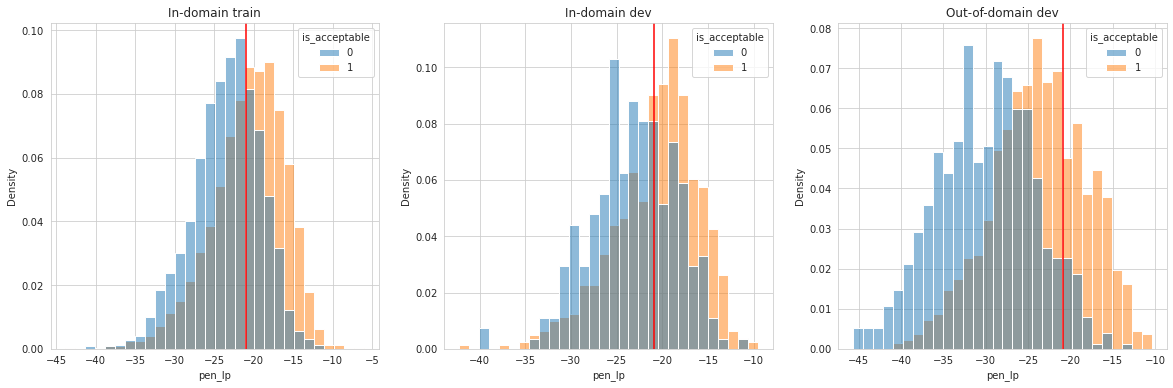

In [12]:
for metric in ['pen_lp']:
    plot_metric(train, in_dev, out_dev, metric, th)